# –ì–µ–Ω–µ—Ä–∞—Ç–æ—Ä (–±–æ–ª—Ç–∞–ª–∫–∞)

In [ ]:
!pip install -q transformers[torch]

In [ ]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import torch

model_name_or_path = "sberbank-ai/rugpt3medium_based_on_gpt2"
tokenizer = GPT2Tokenizer.from_pretrained("sberbank-ai/rugpt3medium_based_on_gpt2")
model = GPT2LMHeadModel.from_pretrained(model_name_or_path)

In [ ]:
def respond_to_dialog(texts):
    prefix = '\nx:'
    for i, t in enumerate(texts):
        prefix += t
        prefix += '\nx:' if i % 2 == 1 else '\ny:'
    tokens = tokenizer(prefix, return_tensors='pt')
    tokens = {k: v.to(model.device) for k, v in tokens.items()}
    end_token_id = tokenizer.encode('\n')[0]
    size = tokens['input_ids'].shape[1]
    output = model.generate(
        **tokens,
        eos_token_id=end_token_id,
        do_sample=True,
        max_length=size+128,
        repetition_penalty=3.2,
        temperature=1,
        num_beams=3,
        length_penalty=0.01,
        pad_token_id=end_token_id
    )
    decoded = tokenizer.decode(output[0])
    result = decoded[len(prefix):]
    return result.strip()

# "–ë–æ—Ç-–ª–µ–∫–∞—Ä—å"

In [ ]:
! unzip /content/drive/MyDrive/NLP–ö—É—Ä—Å–æ–≤–∞—è/medical_qa_ru_data.zip

Archive:  /content/drive/MyDrive/NLP–ö—É—Ä—Å–æ–≤–∞—è/medical_qa_ru_data.zip
  inflating: medical_qa_ru_data.csv  


In [ ]:
#! pip install razdel pymorphy2

In [ ]:
#!wget 'https://drive.google.com/uc?export=download&id=17wVn5YPpMjHToctGgff_KfSeWcIIlf7c' -O stopwords.txt

--2023-09-19 09:54:05--  https://drive.google.com/uc?export=download&id=17wVn5YPpMjHToctGgff_KfSeWcIIlf7c
Resolving drive.google.com (drive.google.com)... 74.125.142.113, 74.125.142.100, 74.125.142.101, ...
Connecting to drive.google.com (drive.google.com)|74.125.142.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0s-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/75fcdqadl1p2crfno2e6ulmph7ar5ljl/1695117225000/14904333240138417226/*/17wVn5YPpMjHToctGgff_KfSeWcIIlf7c?e=download&uuid=b6dba9ab-cdb3-45bf-8c09-66585a5408ba [following]
--2023-09-19 09:54:06--  https://doc-0s-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/75fcdqadl1p2crfno2e6ulmph7ar5ljl/1695117225000/14904333240138417226/*/17wVn5YPpMjHToctGgff_KfSeWcIIlf7c?e=download&uuid=b6dba9ab-cdb3-45bf-8c09-66585a5408ba
Resolving doc-0s-c0-docs.googleusercontent.com (doc-0s-c0-docs.googleusercontent.com)... 74.125.199.132, 2607:

In [ ]:
import numpy as np
import pandas as pd
import re
#from corus import load_rudrec
from tqdm import tqdm_notebook
from transformers import AutoTokenizer, AutoModelForCausalLM, DataCollatorForLanguageModeling,  TFAutoModelForSequenceClassification, Trainer, TrainingArguments
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, classification_report
#from razdel import tokenize
#import pymorphy2
import nltk
# from nltk.corpus import stopwords
# nltk.download('stopwords')
from tqdm import tqdm
tqdm.pandas()

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# stopword_ru = stopwords.words('russian')
# with open('stopwords.txt') as f:
#     additional_stopwords = [w.strip() for w in f.readlines() if w]

# stopword_ru += additional_stopwords

In [ ]:
data = pd.read_csv('medical_qa_ru_data.csv')
data.head(5)

date                categ  \
0   8 –û–∫—Ç—è–±—Ä—è 2017, 11:55  –û—Ç–æ—Ä–∏–Ω–æ–ª–∞—Ä–∏–Ω–≥–æ–ª–æ–≥–∏—è   
1  20 –§–µ–≤—Ä–∞–ª—è 2019, 13:24           –ê–∫—É—à–µ—Ä—Å—Ç–≤–æ   
2    17 –ú–∞—Ä—Ç–∞ 2015, 18:31               –î—Ä—É–≥–æ–µ   
3   13 –Ø–Ω–≤–∞—Ä—è 2019, 19:38              –¢–µ—Ä–∞–ø–∏—è   
4   28 –ù–æ—è–±—Ä—è 2017, 21:58               –î—Ä—É–≥–æ–µ   

                              theme  \
0            –ü—Ä–∏–º–µ–Ω–µ–Ω–∏–µ –õ–∞—Ä–∏–ø—Ä–æ–Ω—Ç–∞.   
1                      –ë–µ—Ä–µ–º–µ–Ω–Ω–æ—Å—Ç—å   
2                       –≥–∏–Ω–µ–∫–æ–ª–æ–≥–∏—è   
3  –ó–∞–Ω—è—Ç–∏—è —Å–ø–æ—Ä—Ç–∞ –ø–æ—Å–ª–µ —Å–¥–∞—á–∏ –∫—Ä–æ–≤–∏   
4                          –¢–∞–±–ª–µ—Ç–∫–∏   

                                                desc  \
0  –õ–∞—Ä–∏–ø—Ä–æ–Ω—Ç 20 —Ç–∞–ª–µ—Ç–æ–∫,—á–µ—Ä–µ–∑ –∫–∞–∂–¥—ã–µ 2-3 —á–∞—Å–∞.–û—á–µ...   
1  –ó–¥—Ä–∞–≤—Å—Ç–≤—É–π—Ç–µ, —è –Ω–∞ 7-8 –Ω–µ–¥–µ–ª–µ –±–µ—Ä–µ–º–µ–Ω–Ω–æ—Å—Ç–∏. –° ...   
2  –ó–¥—Ä–∞–≤—Å—Ç–≤—É–π—Ç–µ –º–µ—Å—è—á–Ω—ã–µ –¥–æ–ª–∂–Ω—ã –ø—Ä–∏–¥—Ç–∏ 23 –º–∞—Ä—Ç–∞ –≤...   
3  –ó–∞–≤—Ç—Ä–∞ –∏–¥—É —Å —É—Ç—Ä–∞ —Å–¥–∞–≤–∞—Ç—å –∫—Ä–æ–≤—å –¢–¢–ì, –¢4–°–í, –ö–∞–ª...   
4  –ú–Ω–µ –ø—Ä–æ–ø–∏—Å–∞–ª–∏ –ø–∏—Ç—å –ê–ª–ª–æ—Ö–æ–ª. –í—Ä–∞—á –Ω–∞–ø–∏—Å–∞–ª–∞ –ø–∏—Ç—å...   

                                                 ans         spec10  
0  –ß—Ç–æ –≤—ã –∏–º –ª–µ—á–∏—Ç–µ? –î–ª–∏—Ç–µ–ª—å–Ω–æ—Å—Ç—å –ø—Ä–∏–µ–º–∞ –õ–∞—Ä–∏–ø—Ä–æ–Ω...  –û—Ç–æ–ª–∞—Ä–∏–Ω–≥–æ–ª–æ–≥  
1  –ó–¥—Ä–∞–≤—Å—Ç–≤—É–π—Ç–µ, —ç—Ç–æ –º–æ–∂–µ—Ç –±—ã—Ç—å –ø—Ä–∏–∑–Ω–∞–∫–æ–º —Ä–∞–Ω–Ω–µ–≥–æ...            NaN  
2                         –í—ã–ø–æ–ª–Ω–∏—Ç–µ –∏—Å—Å–ª–µ–¥–æ–≤–∞–Ω–∏–µ —Ö–≥—á            NaN  
3  –ú–æ–∂–Ω–æ.;\n–ó–¥—Ä–∞–≤—Å—Ç–≤—É–π—Ç–µ , –¥–∞, –ø–æ–ø–µ–π—Ç–µ —Å–ª–∞–¥–∫–æ–≥–æ —á...       –¢–µ—Ä–∞–ø–µ–≤—Ç  
4  –ü—Ä–µ–ø–∞—Ä–∞—Ç –ø—Ä–∏–Ω–∏–º–∞–µ—Ç—Å—è –ø–æ—Å–ª–µ –µ–¥—ã. –£—Ç–æ—á–Ω–∏—Ç–µ —ç—Ç–æ  ...            NaN

In [ ]:
# data.ans = data.ans.apply(lambda x: re.split(r';\n', str(x))[0])
# data.ans[0]

In [ ]:
data = data[['desc', 'ans']]
data.dropna(subset=['desc', 'ans'], inplace=True)
data

desc  \
0       –õ–∞—Ä–∏–ø—Ä–æ–Ω—Ç 20 —Ç–∞–ª–µ—Ç–æ–∫,—á–µ—Ä–µ–∑ –∫–∞–∂–¥—ã–µ 2-3 —á–∞—Å–∞.–û—á–µ...   
1       –ó–¥—Ä–∞–≤—Å—Ç–≤—É–π—Ç–µ, —è –Ω–∞ 7-8 –Ω–µ–¥–µ–ª–µ –±–µ—Ä–µ–º–µ–Ω–Ω–æ—Å—Ç–∏. –° ...   
2       –ó–¥—Ä–∞–≤—Å—Ç–≤—É–π—Ç–µ –º–µ—Å—è—á–Ω—ã–µ –¥–æ–ª–∂–Ω—ã –ø—Ä–∏–¥—Ç–∏ 23 –º–∞—Ä—Ç–∞ –≤...   
3       –ó–∞–≤—Ç—Ä–∞ –∏–¥—É —Å —É—Ç—Ä–∞ —Å–¥–∞–≤–∞—Ç—å –∫—Ä–æ–≤—å –¢–¢–ì, –¢4–°–í, –ö–∞–ª...   
4       –ú–Ω–µ –ø—Ä–æ–ø–∏—Å–∞–ª–∏ –ø–∏—Ç—å –ê–ª–ª–æ—Ö–æ–ª. –í—Ä–∞—á –Ω–∞–ø–∏—Å–∞–ª–∞ –ø–∏—Ç—å...   
...                                                   ...   
190328  –ù–µ –∫—É—Ä—é –∏ –Ω–µ –ø—å—é. –í–µ–¥—É –∑–¥–æ—Ä–æ–≤—ã–π –æ–±—Ä–∞–∑ –∂–∏–∑–Ω–∏, –º...   
190329  –ó–¥—Ä–∞–≤—Å—Ç–≤—É–π—Ç–µ, –æ—á–µ–Ω—å –ø—Ä–æ—à—É –∫–æ–Ω—Å—É–ª—å—Ç–∞—Ü–∏–∏. –í –ª–µ–≤–æ...   
190330  –ó–¥—Ä–∞–≤—Å—Ç–≤—É–π—Ç–µ! –í –≥–ª–∞–∑ –æ—Ç–ª–µ—Ç–µ–ª –∫—É—Å–æ–∫ –ø–ª–∞—Å—Ç–º–∞—Å—Å—ã,...   
190332  –ó–¥—Ä–∞–≤—Å—Ç–≤—É–π—Ç–µ, —Ç—Ä–∏ –¥–Ω—è –Ω–∞–∑–∞–¥ –ø–æ—Ä–µ–∑–∞–ª–∞ –ø–∞–ª–µ—Ü  –±—É...   
190334  –ó–¥—Ä–∞–≤—Å—Ç–≤—É–π—Ç–µ! –ü—Ä–æ—Ö–æ–¥–∏–ª–∞ –ø–æ —Ä–∞–±–æ—Ç–µ –ø–ª–∞–Ω–æ–≤—É—é –∫–æ–º...   

                                                      ans  
0       –ß—Ç–æ –≤—ã –∏–º –ª–µ—á–∏—Ç–µ? –î–ª–∏—Ç–µ–ª—å–Ω–æ—Å—Ç—å –ø—Ä–∏–µ–º–∞ –õ–∞—Ä–∏–ø—Ä–æ–Ω...  
1       –ó–¥—Ä–∞–≤—Å—Ç–≤—É–π—Ç–µ, —ç—Ç–æ –º–æ–∂–µ—Ç –±—ã—Ç—å –ø—Ä–∏–∑–Ω–∞–∫–æ–º —Ä–∞–Ω–Ω–µ–≥–æ...  
2                              –í—ã–ø–æ–ª–Ω–∏—Ç–µ –∏—Å—Å–ª–µ–¥–æ–≤–∞–Ω–∏–µ —Ö–≥—á  
3       –ú–æ–∂–Ω–æ.;\n–ó–¥—Ä–∞–≤—Å—Ç–≤—É–π—Ç–µ , –¥–∞, –ø–æ–ø–µ–π—Ç–µ —Å–ª–∞–¥–∫–æ–≥–æ —á...  
4       –ü—Ä–µ–ø–∞—Ä–∞—Ç –ø—Ä–∏–Ω–∏–º–∞–µ—Ç—Å—è –ø–æ—Å–ª–µ –µ–¥—ã. –£—Ç–æ—á–Ω–∏—Ç–µ —ç—Ç–æ  ...  
...                                                   ...  
190328  –í –ø–µ—Ä–≤—É—é –æ—á–µ—Ä–µ–¥—å –≤–∞–º –Ω–µ–æ–±—Ö–æ–¥–∏–º–æ –æ–±—Å–ª–µ–¥–æ–≤–∞—Ç—å –ø–µ...  
190329  –ù–∞—á–∏–Ω–∞—Ç—å —Å–ª–µ–¥—É–µ—Ç —Å —Ç–µ—Ä–∞–ø–µ–≤—Ç–∏—á–µ—Å–∫–∏—Ö –º–µ—Ç–æ–¥–æ–≤. –ï—Å...  
190330  –†–æ–º–∞—à–∫–∞ –µ—Å—Ç—å –¥–æ–º–∞, –∞–ª—å–±—É—Ü–∏–¥;\n–ú–æ–∂–Ω–æ –ø—Ä–æ–º—ã—Ç—å –ª—é...  
190332  –ó–¥—Ä–∞–≤—Å—Ç–≤—É–π—Ç–µ , –ø–æ–∫–∞ –æ–±—Ä–∞–±–æ—Ç–∞—Ç—å –•–ª–æ—Ä–≥–µ–∫—Å–∏–¥–∏–Ω–æ–º ...  
190334  –ó–¥—Ä–∞–≤—Å—Ç–≤—É–π—Ç–µ,–º–æ–≥–ª–∏ –∫–∞–ø–ª–∏ –≤ –Ω–æ—Å –ü–æ–ª–∏–¥–µ–∫—Å–∞ –ø–æ–≤–ª–∏...  

[171337 rows x 2 columns]

In [ ]:
def clean_text(text):
    res = str(text).strip()
    res = re.sub(r';\n', " ", res)
    res = re.sub(r"[^–ê-–Ø–∞-—è0-9]", " ", res)
    # tokens = list(tokenize(res))
    # words = [_.text for _ in tokens]
    # words_without_stopwords = [i for i in words if not i in stopword_ru]
    return res#' '.join(words_without_stopwords)

# cache = {}
# morph = pymorphy2.MorphAnalyzer()

# def lemmatization(text):

#     if not isinstance(text, str):
#         text = str(text)


#     tokens = list(tokenize(text))
#     words = [_.text for _ in tokens]

#     words_lem = []
#     for w in words:
#         if w[0] == '-':
#             w = w[1:]
#         if len(w) > 1:
#             if w in cache:
#                 words_lem.append(cache[w])
#             else:
#                 temp_cach = cache[w] = morph.parse(w)[0].normal_form
#                 words_lem.append(temp_cach)

#     words_lem_without_stopwords = [i for i in words_lem if not i in stopword_ru]

#     return ' '.join(words_lem_without_stopwords)

# def preproc_text(text):
#   temp = clean_text(text)
#   res = lemmatization(temp)
#   return res


def build_data(data_q, data_ans):
    data = []
    for idx, texts in enumerate(data_q):
        question = texts
        answer = data_ans.iloc[idx]
        res = '\nx:' + question + '\ny:' + answer
        data.append(res)
    return data

In [ ]:
data['desc'] = data['desc'].progress_apply(lambda x: clean_text(x))

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 171337/171337 [00:04<00:00, 34874.22it/s]


In [ ]:
data['ans'] = data['ans'].progress_apply(lambda x: clean_text(x))

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 171337/171337 [00:06<00:00, 26486.25it/s]


In [ ]:
text_train, text_valid, y_train, y_valid = train_test_split(data['desc'],
                                                            data['ans'],
                                                            test_size=.2,
                                                            random_state=42)

In [ ]:
import torch
device = torch.device("cuda")

In [ ]:
model_name = 'sberbank-ai/rugpt3small_based_on_gpt2'
tokenizer_1 = AutoTokenizer.from_pretrained(model_name)
model_1 = AutoModelForCausalLM.from_pretrained(model_name).to(device)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
train_data = build_data(text_train, y_train)
test_data = build_data(text_valid, y_valid)

In [ ]:
tokenizer_1.pad_token = tokenizer_1.eos_token

In [ ]:
train_encodings = tokenizer_1(train_data, padding='max_length', truncation=True, max_length=512, return_tensors='pt')
test_encodings = tokenizer_1(test_data, padding='max_length', truncation=True, max_length=512, return_tensors='pt')

In [ ]:
class QAMedicalDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

train_dataset = QAMedicalDataset(train_encodings)
test_dataset = QAMedicalDataset(test_encodings)
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer_1, mlm=False)

In [ ]:
training_args = TrainingArguments(
    output_dir="./qa_medical", #The output directory
    overwrite_output_dir=True, #overwrite the content of the output directory
    num_train_epochs=3, # number of training epochs
    per_device_train_batch_size=4, # batch size for training
    per_device_eval_batch_size=4,  # batch size for evaluation
    eval_steps = 400, # Number of update steps between two evaluations.
    save_steps=800, # after # steps model is saved
    warmup_steps=500,# number of warmup steps for learning rate scheduler
    )

In [ ]:
trainer = Trainer(
    model=model_1,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

In [ ]:
trainer.train()

In [ ]:
tokenize_1.save_pretrained(path + 'tokenizer_qa_medical_gen')
model_1.save_pretrained(path + 'model_qa_medical_gen')

In [ ]:
tokenizer_1 = AutoTokenizer.from_pretrained(path + 'tokenizer_qa_medical_gen')
model_1 = AutoModelForCausalLM.from_pretrained(path + 'model_qa_medical_gen')

In [ ]:
def respond_to_dialog_med(texts):
    prefix = '\nx:'
    for i, t in enumerate(texts):
        prefix += t
        prefix += '\nx:' if i % 2 == 1 else '\ny:'
    tokens = tokenizer_1(prefix, return_tensors='pt')
    tokens = {k: v.to(model_1.device) for k, v in tokens.items()}
    end_token_id = tokenizer_1.encode('\n')[0]
    size = tokens['input_ids'].shape[1]
    output = model_1.generate(
        **tokens,
        eos_token_id=end_token_id,
        do_sample=True,
        max_length=size+128,
        repetition_penalty=3.2,
        temperature=1,
        num_beams=3,
        length_penalty=0.01,
        pad_token_id=end_token_id
    )
    decoded = tokenizer_1.decode(output[0])
    result = decoded[len(prefix):]
    return result.strip()

# Bot

In [ ]:
!pip install pytelegrambotapi

     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 232.8/232.8 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pytelegrambotapi: filename=pyTelegramBotAPI-4.13.0-py3-none-any.whl size=214529 sha256=bb1d8b7488af2912f0cece7b713c627564de6086d296c7b5ccb405b09793c17d
  Stored in directory: /root/.cache/pip/wheels/f7/1a/3b/41e1ce64625e3f11567085dc79043d9fa573a2cc39f9938556
Successfully built pytelegrambotapi


In [ ]:
history_dialog = []

def babbler(text):
    global history_dialog

    history_dialog.append(text)
    history_dialog.append(respond_to_dialog(history_dialog[-10:]))
    if len(history_dialog) > 10: history_dialog = history_dialog[-10:]

    return history_dialog[-1]

In [ ]:
history = []
def q_a_med(text):
    history.append(text)
    history.append(respond_to_dialog_med(history[-10:]))
    if len(history) > 10: history = history[-10:]

    return history[-1]

In [ ]:
import telebot
from telebot import types

# –°–æ–∑–¥–∞–µ–º —ç–∫–∑–µ–º–ø–ª—è—Ä –±–æ—Ç–∞
bot = telebot.TeleBot("6661137834:AAF4UpCDuiidmiQAjMbV_DeRH4Y-ILZHYs0")

# –§—É–Ω–∫—Ü–∏—è, –æ–±—Ä–∞–±–∞—Ç—ã–≤–∞—é—â–∞—è –∫–æ–º–∞–Ω–¥—É /start
@bot.message_handler(commands=['start'])
def start(message):
    markup = types.ReplyKeyboardMarkup(resize_keyboard=True)
    btn1 = types.KeyboardButton("–ü—Ä–∏–≤–µ—Ç")
    markup.add(btn1)
    bot.send_message(message.chat.id, f"üëã –ü—Ä–∏–≤–µ—Ç {message.from_user.first_name}! –Ø —Ç–≤–æ–π –±–æ—Ç-–ø–æ–º–æ—â–Ω–∏–∫!", reply_markup=markup)

Flag = 0
@bot.callback_query_handler(func=lambda call: True)
def callback_worker(call):
    global Flag
    # –ï—Å–ª–∏ –Ω–∞–∂–∞–ª–∏ –Ω–∞ –æ–¥–Ω—É –∏–∑ –∫–Ω–æ–ø–æ–∫
    if call.data.lower() == '–º–æ–∂–µ–º –ø–æ–±–æ–ª—Ç–∞—Ç—å':
        Flag = 1
        bot.send_message(call.message.chat.id, '–û —á—ë–º —Ö–æ—Ç–∏—Ç–µ –ø–æ–≥–æ–≤–æ—Ä–∏—Ç—å?')
    if call.data.lower() == '–±–æ—Ç-–ª–µ–∫–∞—Ä—å':
        Flag = 2
        bot.send_message(call.message.chat.id, '–ß—Ç–æ –í–∞—Å –±–µ—Å–ø–æ–∫–æ–∏—Ç? ')


# –ü–æ–ª—É—á–µ–Ω–∏–µ —Å–æ–æ–±—â–µ–Ω–∏–π –æ—Ç –ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª—è
@bot.message_handler(content_types=["text"])
def handle_text(message):
    global Flag

    if message.text.lower() == '–ø—Ä–∏–≤–µ—Ç': Flag = 0


    if Flag == 0:# or message.text == '–ù–∞–∑–∞–¥':
        # –ì–æ—Ç–æ–≤–∏–º –∫–Ω–æ–ø–∫–∏
        keyboard = types.InlineKeyboardMarkup()
        # –ò –¥–æ–±–∞–≤–ª—è–µ–º –∫–Ω–æ–ø–∫—É –Ω–∞ —ç–∫—Ä–∞–Ω
        key_oven = types.InlineKeyboardButton(text='–ú–æ–∂–µ–º –ø–æ–±–æ–ª—Ç–∞—Ç—å', callback_data='–º–æ–∂–µ–º –ø–æ–±–æ–ª—Ç–∞—Ç—å')
        # –ò –¥–æ–±–∞–≤–ª—è–µ–º –∫–Ω–æ–ø–∫—É –Ω–∞ —ç–∫—Ä–∞–Ω
        keyboard.add(key_oven)
        key_telec = types.InlineKeyboardButton(text='–ë–æ—Ç-–ª–µ–∫–∞—Ä—å', callback_data='–±–æ—Ç-–ª–µ–∫–∞—Ä—å')
        keyboard.add(key_telec)
        # –ü–æ–∫–∞–∑—ã–≤–∞–µ–º –≤—Å–µ –∫–Ω–æ–ø–∫–∏ —Å—Ä–∞–∑—É –∏ –ø–∏—à–µ–º —Å–æ–æ–±—â–µ–Ω–∏–µ –æ –≤—ã–±–æ—Ä–µ
        bot.send_message(message.chat.id, text='–°–¥–µ–ª–∞–π—Ç–µ, –ø–æ–∂–∞–ª—É–π—Å—Ç–∞, –≤—ã–±–æ—Ä.', reply_markup=keyboard)

    elif Flag == 1:
        bot.send_message(message.chat.id, babbler(message.text))

    elif Flag == 2:
        bot.send_message(message.chat.id, q_a_med(message.text))


# –ó–∞–ø—É—Å–∫–∞–µ–º –±–æ—Ç–∞
bot.polling(none_stop=True, interval=0)

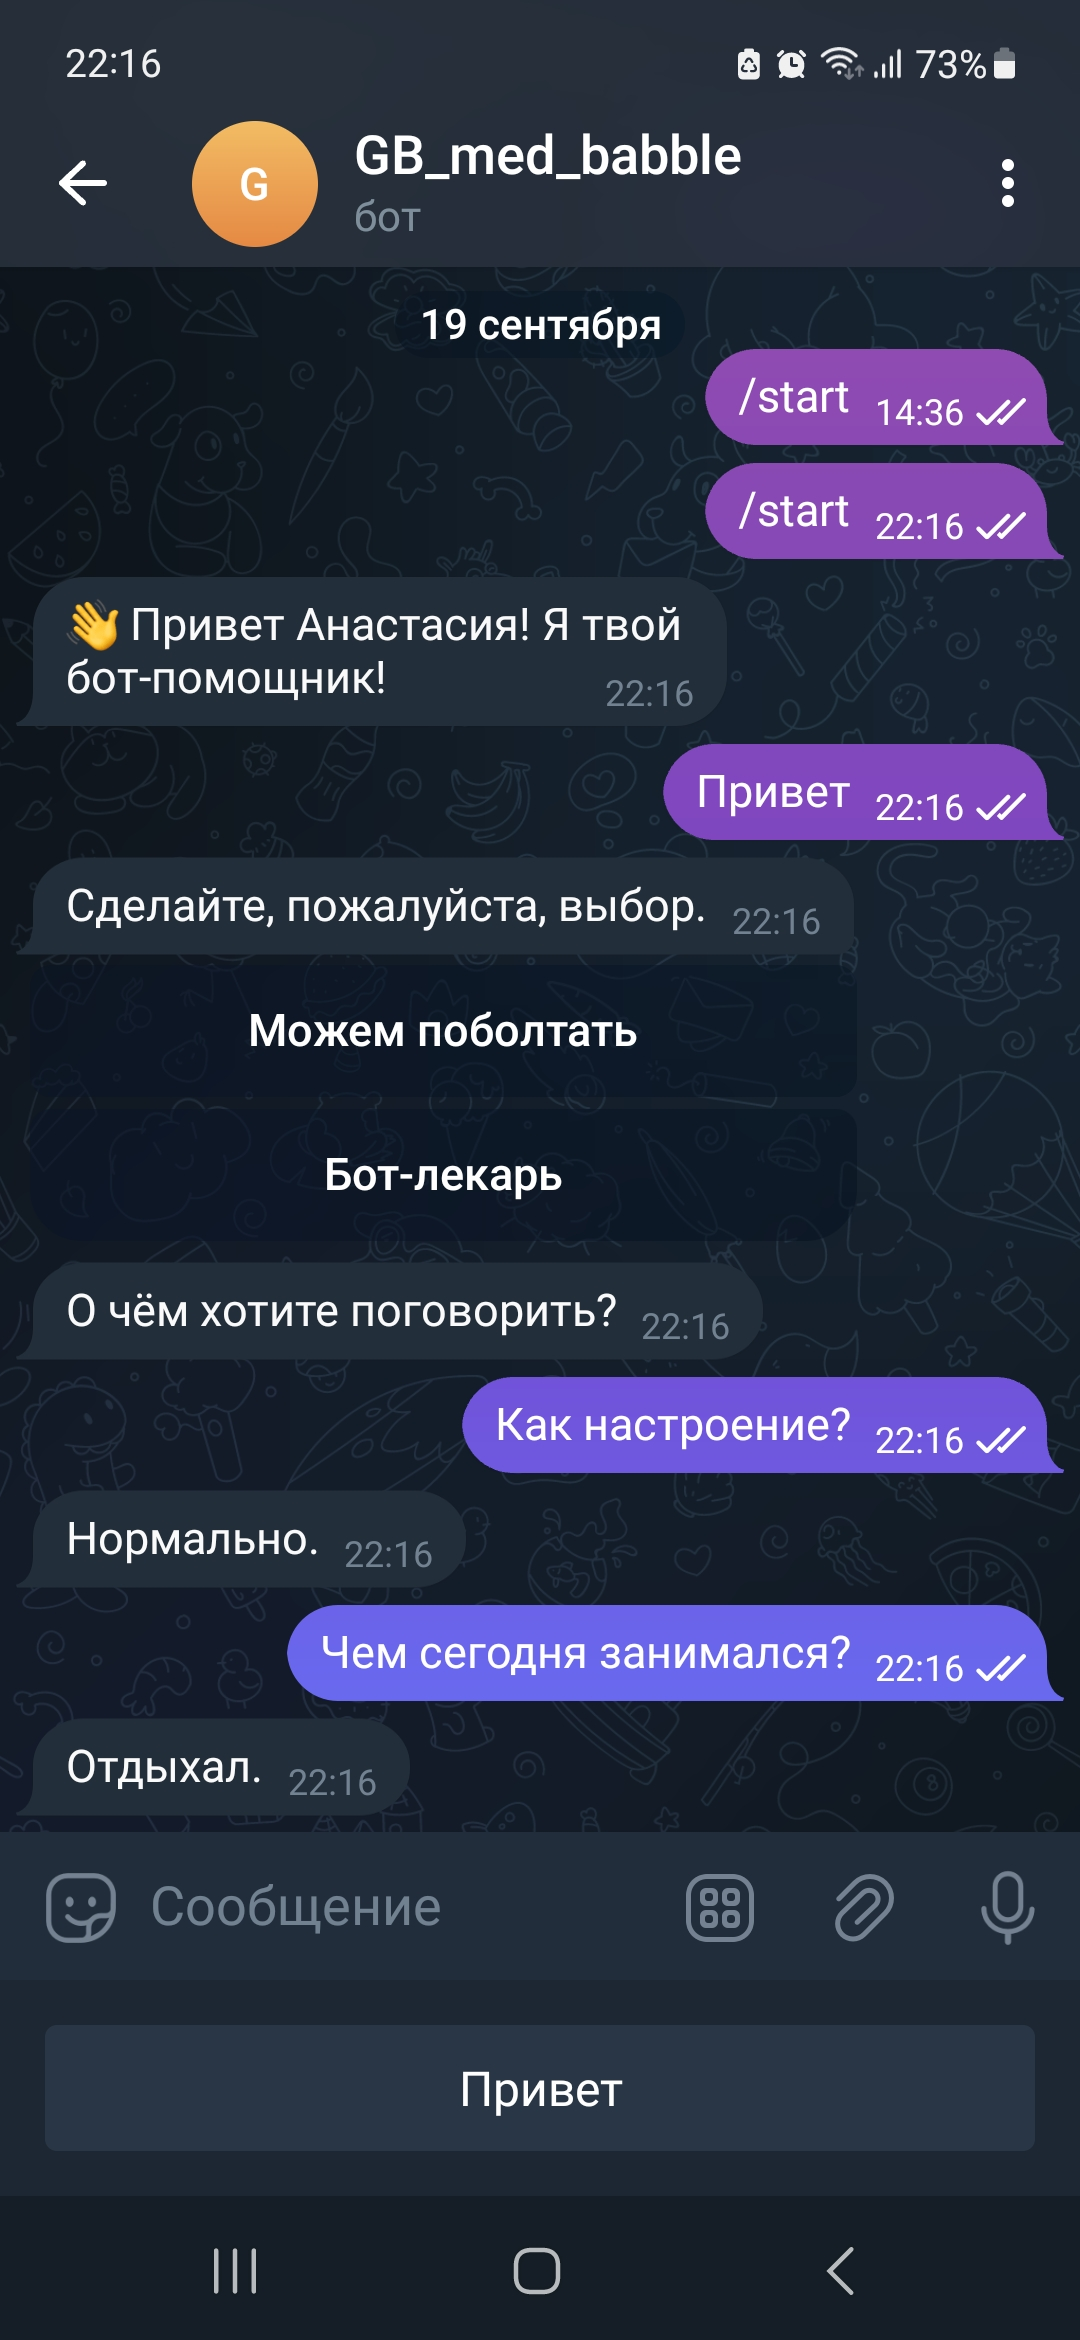

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

# –∑–∞–≥—Ä—É–∂–∞–µ–º –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–µ —Å –¥–∏—Å–∫–∞ –≤ –ø–µ—Ä–µ–º–µ–Ω–Ω—É—é
# –Ω–∞–¥–æ –Ω–∞–ø–∏—Å–∞—Ç—å –∞–¥—Ä–µ—Å –∫ –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏—é –Ω–∞ –≤–∞—à–µ–º –¥–∏—Å–∫–µ
img1 = cv2.imread("/content/drive/MyDrive/NLP–ö—É—Ä—Å–æ–≤–∞—è/Screenshot_20230919_221657_Telegram.jpg")

# –≤—ã–≤–æ–¥–∏–º –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–µ –Ω–∞ —ç–∫—Ä–∞–Ω
cv2_imshow(img1)